In [1]:
import os
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

In [7]:
import numpy as np
import pandas as pd
import pandas_ta as ta
from ta import add_all_ta_features
from ta.utils import dropna
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from bourse_refs_api.models import StockHistory

In [4]:
df = pd.DataFrame(StockHistory.objects.all().values())
df = df.sort_values('date').reset_index(drop=True)
df = dropna(df)

In [5]:
df

,id,stock_id,date,max_price,min_price,last_price,last_deal_price,first_price,yesterday_price,value,volume,count
0,199299,60350996279289096,2018-07-01,3025.0,2875.0,2878,2875,3025.0,3026,43856886482,15240753,623
1,199444,66599109405217136,2018-07-01,11309.0,10512.0,10634,10512,10655.0,10800,58424918,5494,18
2,199443,66142616039907392,2018-07-01,10099.0,9570.0,9797,9799,10000.0,9989,1246590524,127241,58
3,199442,65671173927025648,2018-07-01,3560.0,3351.0,3449,3420,3498.0,3417,4847834909,1405640,267
4,199441,65018804181564928,2018-07-01,973.0,909.0,922,914,950.0,956,982481651,1065051,211
...,...,...,...,...,...,...,...,...,...,...,...,...
424152,465128,38713440086361984,2021-08-10,11550.0,11300.0,11532,11550,11550.0,11433,836923048,72576,26
424153,465127,3823243780502959,2021-08-10,11950.0,11410.0,11730,11760,11800.0,11610,15594905390,1329577,407
424154,465126,38568786927478800,2021-08-10,69100.0,66500.0,68530,69080,66900.0,65810,306157538190,4467581,1083
424155,465137,33420285433308220,2021-08-10,126050.0,120000.0,125700,126050,120000.0,120050,75723841080,602402,416


In [12]:
'''
df = add_all_ta_features(
    df,
    open="first_price",
    high="max_price",
    low="min_price",
    close="last_deal_price",
    volume="volume",
    fillna=True
)
'''


def group_features(group):
    try:
        return add_all_ta_features(
            group.sort_values('date'),
            open="first_price",
            high="max_price",
            low="min_price",
            close="last_deal_price",
            volume="volume",
            fillna=True
        )
    except:
        return group

    
feature_df = df.groupby('stock_id').apply(group_features)

/usr/local/lib/python3.9/site-packages/ta/trend.py:798: RuntimeWarning: invalid value encountered in double_scalars
  dip[i + self._window] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.9/site-packages/ta/trend.py:813: RuntimeWarning: invalid value encountered in double_scalars
  din[i + self._window] = 100 * (self._din[i] / self._trs[i])


In [14]:
feature_df = feature_df.dropna()

In [9]:
plot_df = df.tail(100)

In [11]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from datetime import datetime

fig = make_subplots(rows=2, cols=1)

fig.append_trace(go.Candlestick(
    x=plot_df['date'],
    open=plot_df['first_price'],
    high=plot_df['max_price'],
    low=plot_df['min_price'],
    close=plot_df['last_deal_price']
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=plot_df['date'],
    y=plot_df['momentum_rsi']
), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)

fig.show()

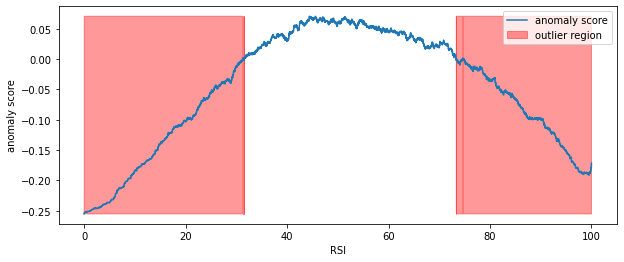

In [17]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(feature_df['momentum_rsi'].values.reshape(-1, 1))
xx = np.linspace(feature_df['momentum_rsi'].min(), feature_df['momentum_rsi'].max(), len(feature_df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('RSI')
plt.show();

In [23]:
outlier_rsi = sorted(xx.T[0][np.where(outlier==-1)])

In [27]:
gap_left, gap_right, max_gap = 0, 0, 0

for i in range(len(outlier_rsi) - 1):
    gap = outlier_rsi[i + 1] - outlier_rsi[i]
    if gap > max_gap:
        gap_left = outlier_rsi[i]
        gap_right = outlier_rsi[i + 1]
        max_gap = gap

In [28]:
gap_left, gap_right

(31.548237155713792, 73.27473668595164)